# <b><font color='red'> Assignment 13 </font>- Apply GBDT on Donors Choose dataset</b>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! pip install chart_studio

     |████████████████████████████████| 71kB 2.4MB/s 


In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re 
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer 

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from chart_studio.plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import seaborn as sea
from scipy.sparse import hstack
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

from prettytable import PrettyTable

Output hidden; open in https://colab.research.google.com to view.

## <b><font color='red'>>> Reading Dataset</font></b>

In [5]:
Project_Dataframe = pd.read_csv('/content/drive/My Drive/Datasets/Apply Naive Bayes on Donor Choose Dataset/train_data.csv')
Resource_Dataframe = pd.read_csv('/content/drive/My Drive/Datasets/Apply Naive Bayes on Donor Choose Dataset/resources.csv')

In [6]:
print('Number of Tain Data Points : ', Project_Dataframe.shape, '\n')
print('- -'*50, '\n')
print('Columns in Project Dataframe : \n\n', Project_Dataframe.columns.values, '\n')
print('- -'*50, '\n')
Project_Dataframe.head(5)

Number of Tain Data Points :  (109248, 17) 

- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- - 

Columns in Project Dataframe : 

 ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved'] 

- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- - 



,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1


In [7]:
# https://stackoverflow.com/a/2582163/4084039
# https://stackoverflow.com/a/49702492/4084039
# https://stackoverflow.com/a/13148611/4084039

cols = ['Date' if x=='project_submitted_datetime' else x for x in list(Project_Dataframe.columns)]
Project_Dataframe['Date'] = pd.to_datetime(Project_Dataframe['project_submitted_datetime'])
Project_Dataframe.drop('project_submitted_datetime', axis = 1, inplace = True)
Project_Dataframe.sort_values(by = ['Date'], inplace = True)
Project_Dataframe = Project_Dataframe[cols]
Project_Dataframe.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Math & Science,"Applied Sciences, Health & Life Science",Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Special Needs,Special Needs,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1


In [8]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step

Price_data = Resource_Dataframe.groupby('id').agg({'quantity':'sum', 'price':'sum'}).reset_index()
Project_Dataframe = pd.merge(Project_Dataframe, Price_data, on = 'id', how = 'left')
Project_Dataframe.head(5)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,quantity,price
0,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Math & Science,"Applied Sciences, Health & Life Science",Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1,4,725.05
1,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Special Needs,Special Needs,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1,8,213.03
2,74477,p189804,4a97f3a390bfe21b99cf5e2b81981c73,Mrs.,CA,2016-04-27 00:46:53,Grades PreK-2,Literacy & Language,Literacy,Mobile Learning with a Mobile Listening Center,Having a class of 24 students comes with diver...,I have a class of twenty-four kindergarten stu...,By having a mobile listening and storage cente...,A mobile listening center will help keep equip...,My students need a mobile listening center to ...,10,1,1,329.00
3,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,Mrs.,GA,2016-04-27 00:53:00,Grades PreK-2,Applied Learning,Early Development,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1,9,481.04
4,33679,p137682,06f6e62e17de34fcf81020c77549e1d5,Mrs.,WA,2016-04-27 01:05:25,Grades 3-5,Literacy & Language,Literacy,Going Deep: The Art of Inner Thinking!,"My students crave challenge, they eat obstacle...","We are an urban, public k-5 elementary school....",With the new common core standards that have b...,These remarkable gifts will provide students w...,My students need copies of the New York Times ...,2,1,14,17.74


In [9]:
print('Number of Tain Data Points : ', Resource_Dataframe.shape, '\n')
print('- -'*50, '\n')
print('Columns in Project Dataframe : \n\n', Resource_Dataframe.columns.values, '\n')
print('- -'*50, '\n')
Resource_Dataframe.head(5)

Number of Tain Data Points :  (1541272, 4) 

- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- - 

Columns in Project Dataframe : 

 ['id' 'description' 'quantity' 'price'] 

- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- - 



,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


## <font color='blue'> >> Preprocessing of 'project_subject_categories' </font>

In [10]:
# https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

Catogories = list(Project_Dataframe['project_subject_categories'].values)

cat_list = []
for i in Catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_')  
    cat_list.append(temp.strip())
    
Project_Dataframe['clean_categories'] = cat_list
Project_Dataframe.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in Project_Dataframe['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

## <font color='blue'>>> Preprocessing of 'project_subject_subcategories' </font>

In [11]:
# https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_Catogories = list(Project_Dataframe['project_subject_subcategories'].values)

sub_cat_list = []
for i in sub_Catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j = j.replace('The','')
        j = j.replace(' ','')
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

Project_Dataframe['clean_subcategories'] = sub_cat_list
Project_Dataframe.drop(['project_subject_subcategories'], axis=1, inplace=True)

# https://stackoverflow.com/a/22898595/4084039

my_counter = Counter()
for word in Project_Dataframe['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## <font color='blue'>>> Text preprocessing</font>

In [12]:
# Merge Two Column Text Dataframe: 

Project_Dataframe['essay'] = Project_Dataframe['project_essay_1'].map(str) +\
                        Project_Dataframe['project_essay_2'].map(str) + \
                        Project_Dataframe['project_essay_3'].map(str) + \
                        Project_Dataframe['project_essay_4'].map(str)

In [13]:
# Print some Random Reviews

"""print(Project_Dataframe['essay'].values[0])
print("- -"*70)
print(Project_Dataframe['essay'].values[150])
print("- -"*70)
print(Project_Dataframe['essay'].values[1050])
print("- -"*70)"""
print(Project_Dataframe['essay'].values[20150])
print("- -"*70)
# print(Project_Dataframe['essay'].values[99999])
# print("- -"*70)

\"When we fill our thoughts with right things, the wrong ones have no room to enter.\" -Joyce Meyer \r\n\r\nMy students come from many different backgrounds. I teach ESL students within my middle school classroom representing over 10 different countries. Besides teaching Engkish to speakers of other languages I am also responsible for their Language Arts curriculum.\r\n\r\nI am hoping this will encourage them to focus on their success and achievement and to be excited about their learning and bring some fun into note taking!These materials of supplemental books and supplies will help my students find even greater meaning in their Springboard curriculum.  While the curriculum itself provides many excerpts in each unit, having supplemental books to read and explore that correlate with each topic will really help to push my students further.  Other supplies ordered will help to provide center and writing activities to help bring greater meaning to unit topics like \"Changes in me\", \"The

In [14]:
# https://stackoverflow.com/a/47091490/4084039

import re

def Decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

In [15]:
sent = Decontracted(Project_Dataframe['essay'].values[20150])
print(sent)
print("- -"*70)

\"When we fill our thoughts with right things, the wrong ones have no room to enter.\" -Joyce Meyer \r\n\r\nMy students come from many different backgrounds. I teach ESL students within my middle school classroom representing over 10 different countries. Besides teaching Engkish to speakers of other languages I am also responsible for their Language Arts curriculum.\r\n\r\nI am hoping this will encourage them to focus on their success and achievement and to be excited about their learning and bring some fun into note taking!These materials of supplemental books and supplies will help my students find even greater meaning in their Springboard curriculum.  While the curriculum itself provides many excerpts in each unit, having supplemental books to read and explore that correlate with each topic will really help to push my students further.  Other supplies ordered will help to provide center and writing activities to help bring greater meaning to unit topics like \"Changes in me\", \"The

In [16]:
# Remove (\r \n \t) from String in Python: http://texthandler.com/info/remove-line-breaks-python/

sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

 When we fill our thoughts with right things, the wrong ones have no room to enter.  -Joyce Meyer     My students come from many different backgrounds. I teach ESL students within my middle school classroom representing over 10 different countries. Besides teaching Engkish to speakers of other languages I am also responsible for their Language Arts curriculum.    I am hoping this will encourage them to focus on their success and achievement and to be excited about their learning and bring some fun into note taking!These materials of supplemental books and supplies will help my students find even greater meaning in their Springboard curriculum.  While the curriculum itself provides many excerpts in each unit, having supplemental books to read and explore that correlate with each topic will really help to push my students further.  Other supplies ordered will help to provide center and writing activities to help bring greater meaning to unit topics like  Changes in me ,  The Choices we M

In [17]:
# Removing Spacial Character: https://stackoverflow.com/a/5843547/4084039

sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

 When we fill our thoughts with right things the wrong ones have no room to enter Joyce Meyer My students come from many different backgrounds I teach ESL students within my middle school classroom representing over 10 different countries Besides teaching Engkish to speakers of other languages I am also responsible for their Language Arts curriculum I am hoping this will encourage them to focus on their success and achievement and to be excited about their learning and bring some fun into note taking These materials of supplemental books and supplies will help my students find even greater meaning in their Springboard curriculum While the curriculum itself provides many excerpts in each unit having supplemental books to read and explore that correlate with each topic will really help to push my students further Other supplies ordered will help to provide center and writing activities to help bring greater meaning to unit topics like Changes in me The Choices we Make Challengea of Heroi

In [18]:
# https://gist.github.com/sebleier/554280

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [19]:
# https://gist.github.com/sebleier/554280

def filterSentance(sentance):
    sent = Decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = sent.lower()
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    return sent.strip()

In [20]:
# https://gist.github.com/sebleier/554280

preprocessed_essays = []
for sentance in tqdm(Project_Dataframe['essay'].values):
    preprocessed_essays.append(filterSentance(sentance))

100%|██████████| 109248/109248 [00:59<00:00, 1822.59it/s]


In [21]:
preprocessed_essays[20150]

'fill thoughts right things wrong ones no room enter joyce meyer students come many different backgrounds teach esl students within middle school classroom representing 10 different countries besides teaching engkish speakers languages also responsible language arts curriculum hoping encourage focus success achievement excited learning bring fun note taking materials supplemental books supplies help students find even greater meaning springboard curriculum curriculum provides many excerpts unit supplemental books read explore correlate topic really help push students supplies ordered help provide center writing activities help bring greater meaning unit topics like changes choices make challengea heroism challenges facing holocaust materials help students delve deeper themes truly make difference understanding success nannan'

## <font color='blue'> >> Preprocessing of 'project_title'</font>

In [22]:
# Print Some Random essay titles.

"""print(Project_Dataframe['project_title'].values[0])
print("- -"*20)
print(Project_Dataframe['project_title'].values[250])
print("- -"*20)
print(Project_Dataframe['project_title'].values[25010])
print("- -"*20)"""
print(Project_Dataframe['project_title'].values[50055])
print("- -"*20)
# print(Project_Dataframe['project_title'].values[99999])
# print("- -"*20)

Educational Centers
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -


In [23]:
preprocessed_titles = []
for sentance in tqdm(Project_Dataframe['project_title'].values):
    preprocessed_titles.append(filterSentance(sentance))

100%|██████████| 109248/109248 [00:02<00:00, 43200.41it/s]


In [24]:
preprocessed_titles[50055]

'educational centers'

In [25]:
preprocessed_resource_summary = []
for sentance in tqdm(Project_Dataframe['project_resource_summary'].values):
    preprocessed_resource_summary.append(filterSentance(sentance))

100%|██████████| 109248/109248 [00:06<00:00, 18004.72it/s]


In [26]:
preprocessed_resource_summary[20150]

'students need supplemental materials help find success springboard curriculum'

In [27]:
preprocessed_teacher_prefix = []
for teacher_prefix in tqdm(Project_Dataframe['teacher_prefix'].values):
    teacher_prefix = str(teacher_prefix)
    clean_teacher_prefix = Decontracted(teacher_prefix)
    clean_teacher_prefix = clean_teacher_prefix.replace('\\r', ' ')
    clean_teacher_prefix = clean_teacher_prefix.replace('\\"', ' ')
    clean_teacher_prefix = clean_teacher_prefix.replace('\\n', ' ')
    clean_teacher_prefix = re.sub('[^A-Za-z0-9]+', ' ', clean_teacher_prefix)
    clean_teacher_prefix = clean_teacher_prefix.lower()
    if clean_teacher_prefix in stopwords:
        continue
    preprocessed_teacher_prefix.append(clean_teacher_prefix.strip())

100%|██████████| 109248/109248 [00:01<00:00, 78984.18it/s]


In [28]:
preprocessed_teacher_prefix[:10]

['mrs', 'ms', 'mrs', 'mrs', 'mrs', 'mrs', 'mrs', 'ms', 'ms', 'mrs']

In [29]:
preprocessed_project_grade_category = []

for project_grade_category in tqdm(Project_Dataframe['project_grade_category'].values):
    project_grade_category = str(project_grade_category)
    clean_project_grade_category = Decontracted(project_grade_category)
    clean_project_grade_category = clean_project_grade_category.replace('\\r', ' ')
    clean_project_grade_category = clean_project_grade_category.replace('\\"', ' ')
    clean_project_grade_category = clean_project_grade_category.replace('\\n', ' ')
    clean_project_grade_category = re.sub('[^A-Za-z0-9]+', ' ', clean_project_grade_category)
    clean_project_grade_category = clean_project_grade_category.lower()
    if clean_project_grade_category in stopwords:
        continue
    clean_project_grade_category = clean_project_grade_category.strip()
    preprocessed_project_grade_category.append(clean_project_grade_category.replace(' ', '_'))

100%|██████████| 109248/109248 [00:01<00:00, 78048.25it/s]


In [30]:
preprocessed_project_grade_category[:10]

['grades_prek_2',
 'grades_3_5',
 'grades_prek_2',
 'grades_prek_2',
 'grades_3_5',
 'grades_3_5',
 'grades_3_5',
 'grades_3_5',
 'grades_prek_2',
 'grades_3_5']

In [31]:
Project_Dataframe['clean_essays'] = preprocessed_essays
Project_Dataframe['clean_titles'] = preprocessed_titles
Project_Dataframe['project_resource_summary'] = preprocessed_resource_summary
Project_Dataframe['teacher_prefix'] = preprocessed_teacher_prefix
Project_Dataframe['project_grade_category'] = preprocessed_project_grade_category
Project_Dataframe.drop(['project_essay_1'], axis = 1, inplace = True)
Project_Dataframe.drop(['project_essay_2'], axis = 1, inplace = True)
Project_Dataframe.drop(['project_essay_3'], axis = 1, inplace = True)
Project_Dataframe.drop(['project_essay_4'], axis = 1, inplace = True)

In [32]:
Project_Dataframe['teacher_prefix'] = Project_Dataframe['teacher_prefix'].fillna('null')

## <font color='blue'>>> Preparing data for models</font>

In [33]:
y = Project_Dataframe['project_is_approved'].values
Project_Dataframe.drop(['project_is_approved'], axis = 1, inplace = True)
X = Project_Dataframe
Project_Dataframe.shape

(109248, 17)

In [34]:
x_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.33, stratify=y_train)

print('Train Dataset : ', X_train.shape, y_train.shape)
print('Cross Validate Dataset : ', X_cv.shape, y_cv.shape)
print('Test Dataset : ', X_test.shape, y_test.shape)

Train Dataset :  (49041, 17) (49041,)
Cross Validate Dataset :  (24155, 17) (24155,)
Test Dataset :  (36052, 17) (36052,)


### <font color='blue'> TFIDF Vectorizer </font>

In [35]:
vectorizer = TfidfVectorizer(min_df = 10)
vectorizer.fit(X_train['clean_titles'].values)

X_train_title_TFIDF = vectorizer.transform(X_train['clean_titles'].values)
X_cv_title_TFIDF = vectorizer.transform(X_cv['clean_titles'].values)
X_test_title_TFIDF = vectorizer.transform(X_test['clean_titles'].values)
clean_titles_TFIDF_features = vectorizer.get_feature_names()

print("After vectorizations : ")
print(X_train_title_TFIDF.shape, y_train.shape)
print(X_cv_title_TFIDF.shape, y_cv.shape)
print(X_cv_title_TFIDF.shape, y_test.shape)

After vectorizations : 
(49041, 1987) (49041,)
(24155, 1987) (24155,)
(24155, 1987) (36052,)


In [36]:
vectorizer = TfidfVectorizer(min_df = 10)
vectorizer.fit(X_train['clean_essays'].values)

X_train_essay_TFIDF = vectorizer.transform(X_train['clean_essays'].values)
X_cv_essay_TFIDF = vectorizer.transform(X_cv['clean_essays'].values)
X_test_essay_TFIDF = vectorizer.transform(X_test['clean_essays'].values)

easy_TFIDF_features = vectorizer.get_feature_names()

print("After vectorizations : ")
print(X_train_essay_TFIDF.shape, y_train.shape)
print(X_cv_essay_TFIDF.shape, y_cv.shape)
print(X_test_essay_TFIDF.shape, y_test.shape)

After vectorizations : 
(49041, 12111) (49041,)
(24155, 12111) (24155,)
(36052, 12111) (36052,)


In [37]:
vectorizer = TfidfVectorizer(min_df = 10)
vectorizer.fit(X_train['project_resource_summary'].values)

X_train_project_resource_summary_TFIDF = vectorizer.transform(X_train['project_resource_summary'].values)
X_cv_project_resource_summary_TFIDF = vectorizer.transform(X_cv['project_resource_summary'].values)
X_test_project_resource_summary_TFIDF = vectorizer.transform(X_test['project_resource_summary'].values)
project_resource_summary_TFIDF_features = vectorizer.get_feature_names()

print("After vectorizations : ")
print(X_train_project_resource_summary_TFIDF.shape, y_train.shape)
print(X_cv_project_resource_summary_TFIDF.shape, y_cv.shape)
print(X_test_project_resource_summary_TFIDF.shape, y_test.shape)

After vectorizations : 
(49041, 3830) (49041,)
(24155, 3830) (24155,)
(36052, 3830) (36052,)


### <font color='blue'> TFIDF W2V Vectorizer</font>

In [38]:
# http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('/content/drive/My Drive/Datasets/Apply Naive Bayes on Donor Choose Dataset/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [39]:
TFIDF_model = TfidfVectorizer()
TFIDF_model.fit(X_train['clean_essays'])
dictionary = dict(zip(TFIDF_model.get_feature_names(), list(TFIDF_model.idf_)))
TFIDF_words = set(TFIDF_model.get_feature_names())

In [40]:
TFIDFW2V_vectors_text_train = []; 
for sentence in tqdm(X_train['clean_essays']):
    vector = np.zeros(300) 
    tf_idf_weight = 0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in TFIDF_words):
            vec = model[word] 
            tf_idf = dictionary[word] * (sentence.count(word) / len(sentence.split())) 
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    TFIDFW2V_vectors_text_train.append(vector)

100%|██████████| 49041/49041 [01:28<00:00, 552.59it/s]


In [41]:
TFIDFW2V_vectors_text_cv = []; 
for sentence in tqdm(X_cv['clean_essays']): 
    vector = np.zeros(300) 
    tf_idf_weight = 0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in TFIDF_words):
            vec = model[word]
            tf_idf = dictionary[word] * (sentence.count(word) / len(sentence.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    TFIDFW2V_vectors_text_cv.append(vector)

100%|██████████| 24155/24155 [00:43<00:00, 550.40it/s]


In [42]:
TFIDFW2V_vectors_text_test = []; 
for sentence in tqdm(X_test['clean_essays']): 
    vector = np.zeros(300) 
    tf_idf_weight =0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in TFIDF_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    TFIDFW2V_vectors_text_test.append(vector)

100%|██████████| 36052/36052 [01:06<00:00, 544.92it/s]


In [43]:
TFIDF_model = TfidfVectorizer()
TFIDF_model.fit(X_train['clean_titles'])
dictionary = dict(zip(TFIDF_model.get_feature_names(), list(TFIDF_model.idf_)))
TFIDF_words = set(TFIDF_model.get_feature_names())

In [44]:
TFIDFW2V_vectors_title_train = []; 
for sentence in tqdm(X_train['clean_titles']): 
    vector = np.zeros(300) 
    tf_idf_weight = 0; 
    for word in sentence.split():
        if (word in glove_words) and (word in TFIDF_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    TFIDFW2V_vectors_title_train.append(vector)

100%|██████████| 49041/49041 [00:02<00:00, 24466.29it/s]


In [45]:
TFIDFW2V_vectors_title_cv = []; 
for sentence in tqdm(X_cv['clean_titles']): 
    vector = np.zeros(300) 
    tf_idf_weight = 0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in TFIDF_words):
            vec = model[word] 
            tf_idf = dictionary[word] * (sentence.count(word) / len(sentence.split())) 
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    TFIDFW2V_vectors_title_cv.append(vector)

100%|██████████| 24155/24155 [00:01<00:00, 21706.65it/s]


In [46]:
TFIDFW2V_vectors_title_test = [];
for sentence in tqdm(X_test['clean_titles']): 
    vector = np.zeros(300) 
    tf_idf_weight = 0;
    for word in sentence.split():
        if (word in glove_words) and (word in TFIDF_words):
            vec = model[word] 
            tf_idf = dictionary[word] * (sentence.count(word) / len(sentence.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    TFIDFW2V_vectors_title_test.append(vector)

100%|██████████| 36052/36052 [00:01<00:00, 21378.05it/s]


In [47]:
TFIDF_model = TfidfVectorizer()
TFIDF_model.fit(X_train['project_resource_summary'])
dictionary = dict(zip(TFIDF_model.get_feature_names(), list(TFIDF_model.idf_)))
TFIDF_words = set(TFIDF_model.get_feature_names())

In [48]:
TFIDFW2V_vectors_project_resource_summary_train = []; 
for sentence in tqdm(X_train['project_resource_summary']):
    vector = np.zeros(300) 
    tf_idf_weight = 0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in TFIDF_words):
            vec = model[word] 
            tf_idf = dictionary[word] * (sentence.count(word) / len(sentence.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    TFIDFW2V_vectors_project_resource_summary_train.append(vector)

100%|██████████| 49041/49041 [00:05<00:00, 9008.25it/s]


In [49]:
TFIDFW2V_vectors_project_resource_summary_cv = []; 
for sentence in tqdm(X_cv['project_resource_summary']): 
    vector = np.zeros(300) 
    tf_idf_weight = 0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in TFIDF_words):
            vec = model[word] 
            tf_idf = dictionary[word] * (sentence.count(word) / len(sentence.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    TFIDFW2V_vectors_project_resource_summary_cv.append(vector)

100%|██████████| 24155/24155 [00:02<00:00, 9168.97it/s]


In [50]:
TFIDFW2V_vectors_project_resource_summary_test = []; 
for sentence in tqdm(X_test['project_resource_summary']): 
    vector = np.zeros(300) 
    tf_idf_weight = 0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in TFIDF_words):
            vec = model[word] 
            tf_idf = dictionary[word] * (sentence.count(word) / len(sentence.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    TFIDFW2V_vectors_project_resource_summary_test.append(vector)

100%|██████████| 36052/36052 [00:04<00:00, 8691.24it/s]


### <font color='blue'>Vectorizing Numerical features</font>

In [51]:
X_train_quantity_norm = X_train['quantity'].values.reshape(-1, 1)
X_cv_quantity_norm = X_cv['quantity'].values.reshape(-1, 1)
X_test_quantity_norm = X_test['quantity'].values.reshape(-1, 1)

print("After vectorizations : ")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_cv_quantity_norm.shape, y_cv.shape)
print(X_test_quantity_norm.shape, y_test.shape)

After vectorizations : 
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [52]:
X_train_teacher_number_of_previously_posted_projects_norm = X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)
X_cv_teacher_number_of_previously_posted_projects_norm = X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)
X_test_teacher_number_of_previously_posted_projects_norm = X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

print("After vectorizations : ")
print(X_train_teacher_number_of_previously_posted_projects_norm.shape, y_train.shape)
print(X_cv_teacher_number_of_previously_posted_projects_norm.shape, y_cv.shape)
print(X_test_teacher_number_of_previously_posted_projects_norm.shape, y_test.shape)

After vectorizations : 
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [53]:
X_train_price_norm = X_train['price'].values.reshape(-1, 1)
X_cv_price_norm = X_cv['price'].values.reshape(-1, 1)
X_test_price_norm = X_test['price'].values.reshape(-1, 1)

print("After vectorizations : ")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

After vectorizations : 
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### <font color='blue'> Vectorizing Categorical data</font>

In [54]:
def calculate_proba_score_of_each_variable(data, classLabel):

    positive_score_dict = {}
    negative_score_dict = {}
    distinct_feature = []
    
    for i in range(len(data)):
        
        if(data[i] not in distinct_feature):
            distinct_feature.append(data[i])
        if(1 == classLabel[i]):
            if(data[i] in positive_score_dict):
                positive_score_dict[data[i]] = positive_score_dict[data[i]] + 1
            else:
                positive_score_dict[data[i]] = 1
        else:
            if(data[i] in negative_score_dict):
                negative_score_dict[data[i]] = negative_score_dict[data[i]] + 1 
            else:
                negative_score_dict[data[i]] = 1
                
    prob_score = {}

    for i in range(len(distinct_feature)):

        pos_score = 0
        neg_score = 0
        if(distinct_feature[i] in positive_score_dict):
            pos_score = positive_score_dict[distinct_feature[i]]
        if(distinct_feature[i] in negative_score_dict):
            neg_score = negative_score_dict[distinct_feature[i]]
            
        prob_score[distinct_feature[i]] = {"pos" : (pos_score / (pos_score+neg_score)), "neg" : (neg_score / (pos_score+neg_score))}
  
    return prob_score


def convert_response_encoding(data, proba_score):
    
    result_pos = []
    result_neg = []
    for i in range(len(data)):
        if((data[i] in proba_score)):
            result_pos.append(proba_score[data[i]]['pos'])
            result_neg.append(proba_score[data[i]]['neg'])
        else:
            result_pos.append(0.5)
            result_neg.append(0.5)
            
    return [result_pos, result_neg]

In [55]:
from scipy.sparse import coo_matrix

proba_score_train = calculate_proba_score_of_each_variable(X_train['school_state'].values, y_train)
response_encoding_train_pos, response_encoding_train_neg = convert_response_encoding(X_train['school_state'].values, proba_score_train)
response_encoding_train_pos = pd.DataFrame(response_encoding_train_pos)
response_encoding_train_neg = pd.DataFrame(response_encoding_train_neg)

response_encoding_cv_pos, response_encoding_cv_neg = convert_response_encoding(X_cv['school_state'].values, proba_score_train)
response_encoding_cv_pos = pd.DataFrame(response_encoding_cv_pos)
response_encoding_cv_neg = pd.DataFrame(response_encoding_cv_neg)

response_encoding_test_pos, response_encoding_test_neg = convert_response_encoding(X_test['school_state'].values, proba_score_train)
response_encoding_test_pos = pd.DataFrame(response_encoding_test_pos)
response_encoding_test_neg = pd.DataFrame(response_encoding_test_neg)

X_train_school_state_pos = response_encoding_train_pos.values.reshape(-1,1)
X_train_school_state_neg = response_encoding_train_neg.values.reshape(-1,1)
X_cv_school_state_pos = response_encoding_cv_pos.values.reshape(-1,1)
X_cv_school_state_neg = response_encoding_cv_neg.values.reshape(-1,1)
X_test_school_state_pos = response_encoding_test_pos.values.reshape(-1,1)
X_test_school_state_neg = response_encoding_test_neg.values.reshape(-1,1)

X_train_school_state_pos = coo_matrix(X_train_school_state_pos)
X_train_school_state_neg = coo_matrix(X_train_school_state_neg)
X_cv_school_state_pos = coo_matrix(X_cv_school_state_pos)
X_cv_school_state_neg = coo_matrix(X_cv_school_state_neg)
X_test_school_state_pos = coo_matrix(X_test_school_state_pos)
X_test_school_state_neg = coo_matrix(X_test_school_state_neg)

In [56]:
proba_score_train = calculate_proba_score_of_each_variable(X_train['clean_categories'].values, y_train)
response_encoding_train_pos, response_encoding_train_neg = convert_response_encoding(X_train['clean_categories'].values, proba_score_train)
response_encoding_train_pos = pd.DataFrame(response_encoding_train_pos)
response_encoding_train_neg = pd.DataFrame(response_encoding_train_neg)

response_encoding_cv_pos, response_encoding_cv_neg = convert_response_encoding(X_cv['clean_categories'].values, proba_score_train)
response_encoding_cv_pos = pd.DataFrame(response_encoding_cv_pos)
response_encoding_cv_neg = pd.DataFrame(response_encoding_cv_neg)

response_encoding_test_pos, response_encoding_test_neg = convert_response_encoding(X_test['clean_categories'].values, proba_score_train)
response_encoding_test_pos = pd.DataFrame(response_encoding_test_pos)
response_encoding_test_neg = pd.DataFrame(response_encoding_test_neg)

X_train_clean_categories_pos = response_encoding_train_pos.values.reshape(-1,1)
X_train_clean_categories_neg = response_encoding_train_neg.values.reshape(-1,1)
X_cv_clean_categories_pos = response_encoding_cv_pos.values.reshape(-1,1)
X_cv_clean_categories_neg = response_encoding_cv_neg.values.reshape(-1,1)
X_test_clean_categories_pos = response_encoding_test_pos.values.reshape(-1,1)
X_test_clean_categories_neg = response_encoding_test_neg.values.reshape(-1,1)

X_train_clean_categories_pos = coo_matrix(X_train_clean_categories_pos)
X_train_clean_categories_neg = coo_matrix(X_train_clean_categories_neg)
X_cv_clean_categories_pos = coo_matrix(X_cv_clean_categories_pos)
X_cv_clean_categories_neg = coo_matrix(X_cv_clean_categories_neg)
X_test_clean_categories_pos = coo_matrix(X_test_clean_categories_pos)
X_test_clean_categories_neg = coo_matrix(X_test_clean_categories_neg)

In [57]:
proba_score_train = calculate_proba_score_of_each_variable(X_train['clean_subcategories'].values, y_train)
response_encoding_train_pos, response_encoding_train_neg = convert_response_encoding(X_train['clean_subcategories'].values, proba_score_train)
response_encoding_train_pos = pd.DataFrame(response_encoding_train_pos)
response_encoding_train_neg = pd.DataFrame(response_encoding_train_neg)

response_encoding_cv_pos, response_encoding_cv_neg = convert_response_encoding(X_cv['clean_subcategories'].values, proba_score_train)
response_encoding_cv_pos = pd.DataFrame(response_encoding_cv_pos)
response_encoding_cv_neg = pd.DataFrame(response_encoding_cv_neg)

response_encoding_test_pos, response_encoding_test_neg = convert_response_encoding(X_test['clean_subcategories'].values, proba_score_train)
response_encoding_test_pos = pd.DataFrame(response_encoding_test_pos)
response_encoding_test_neg = pd.DataFrame(response_encoding_test_neg)

X_train_clean_subcategories_pos = response_encoding_train_pos.values.reshape(-1,1)
X_train_clean_subcategories_neg = response_encoding_train_neg.values.reshape(-1,1)
X_cv_clean_subcategories_pos = response_encoding_cv_pos.values.reshape(-1,1)
X_cv_clean_subcategories_neg = response_encoding_cv_neg.values.reshape(-1,1)
X_test_clean_subcategories_pos = response_encoding_test_pos.values.reshape(-1,1)
X_test_clean_subcategories_neg = response_encoding_test_neg.values.reshape(-1,1)

X_train_clean_subcategories_pos = coo_matrix(X_train_clean_subcategories_pos)
X_train_clean_subcategories_neg = coo_matrix(X_train_clean_subcategories_neg)
X_cv_clean_subcategories_pos = coo_matrix(X_cv_clean_subcategories_pos)
X_cv_clean_subcategories_neg = coo_matrix(X_cv_clean_subcategories_neg)
X_test_clean_subcategories_pos = coo_matrix(X_test_clean_subcategories_pos)
X_test_clean_subcategories_neg = coo_matrix(X_test_clean_subcategories_neg)

In [58]:
proba_score_train = calculate_proba_score_of_each_variable(X_train['project_grade_category'].values, y_train)
response_encoding_train_pos, response_encoding_train_neg = convert_response_encoding(X_train['project_grade_category'].values, proba_score_train)
response_encoding_train_pos = pd.DataFrame(response_encoding_train_pos)
response_encoding_train_neg = pd.DataFrame(response_encoding_train_neg)

response_encoding_cv_pos, response_encoding_cv_neg = convert_response_encoding(X_cv['project_grade_category'].values, proba_score_train)
response_encoding_cv_pos = pd.DataFrame(response_encoding_cv_pos)
response_encoding_cv_neg = pd.DataFrame(response_encoding_cv_neg)

response_encoding_test_pos, response_encoding_test_neg = convert_response_encoding(X_test['project_grade_category'].values, proba_score_train)
response_encoding_test_pos = pd.DataFrame(response_encoding_test_pos)
response_encoding_test_neg = pd.DataFrame(response_encoding_test_neg)

X_train_project_grade_category_pos = response_encoding_train_pos.values.reshape(-1,1)
X_train_project_grade_category_neg = response_encoding_train_neg.values.reshape(-1,1)
X_cv_project_grade_category_pos = response_encoding_cv_pos.values.reshape(-1,1)
X_cv_project_grade_category_neg = response_encoding_cv_neg.values.reshape(-1,1)
X_test_project_grade_category_pos = response_encoding_test_pos.values.reshape(-1,1)
X_test_project_grade_category_neg = response_encoding_test_neg.values.reshape(-1,1)

X_train_project_grade_category_pos = coo_matrix(X_train_project_grade_category_pos)
X_train_project_grade_category_neg = coo_matrix(X_train_project_grade_category_neg)
X_cv_project_grade_category_pos = coo_matrix(X_cv_project_grade_category_pos)
X_cv_project_grade_category_neg = coo_matrix(X_cv_project_grade_category_neg)
X_test_project_grade_category_pos = coo_matrix(X_test_project_grade_category_pos)
X_test_project_grade_category_neg = coo_matrix(X_test_project_grade_category_neg)

In [59]:
proba_score_train = calculate_proba_score_of_each_variable(X_train['teacher_prefix'].values, y_train)
response_encoding_train_pos, response_encoding_train_neg = convert_response_encoding(X_train['teacher_prefix'].values, proba_score_train)
response_encoding_train_pos = pd.DataFrame(response_encoding_train_pos)
response_encoding_train_neg = pd.DataFrame(response_encoding_train_neg)

response_encoding_cv_pos, response_encoding_cv_neg = convert_response_encoding(X_cv['teacher_prefix'].values, proba_score_train)
response_encoding_cv_pos = pd.DataFrame(response_encoding_cv_pos)
response_encoding_cv_neg = pd.DataFrame(response_encoding_cv_neg)

response_encoding_test_pos, response_encoding_test_neg = convert_response_encoding(X_test['teacher_prefix'].values, proba_score_train)
response_encoding_test_pos = pd.DataFrame(response_encoding_test_pos)
response_encoding_test_neg = pd.DataFrame(response_encoding_test_neg)

X_train_teacher_prefix_pos = response_encoding_train_pos.values.reshape(-1,1)
X_train_teacher_prefix_neg = response_encoding_train_neg.values.reshape(-1,1)
X_cv_teacher_prefix_pos = response_encoding_cv_pos.values.reshape(-1,1)
X_cv_teacher_prefix_neg = response_encoding_cv_neg.values.reshape(-1,1)
X_test_teacher_prefix_pos = response_encoding_test_pos.values.reshape(-1,1)
X_test_teacher_prefix_neg = response_encoding_test_neg.values.reshape(-1,1)

X_train_teacher_prefix_pos = coo_matrix(X_train_teacher_prefix_pos)
X_train_teacher_prefix_neg = coo_matrix(X_train_teacher_prefix_neg)
X_cv_teacher_prefix_pos = coo_matrix(X_cv_teacher_prefix_pos)
X_cv_teacher_prefix_neg = coo_matrix(X_cv_teacher_prefix_neg)
X_test_teacher_prefix_pos = coo_matrix(X_test_teacher_prefix_pos)
X_test_teacher_prefix_neg = coo_matrix(X_test_teacher_prefix_neg)

### <font color='blue'> Merging all the above features</font>

In [60]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [61]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>1. GBDT (xgboost/lightgbm) </h1>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

# <b><font color='red'>Task 1: </font></b>

## <b><font color='blue'>>> Applying GBDT (xgboost) on TFIDF, </font><font color='red'> SET 1</font></b>

In [ ]:
X_train_TFIDF = hstack((X_train_school_state_pos, X_train_school_state_neg, X_train_clean_categories_pos, X_train_clean_categories_neg,
                        X_train_clean_subcategories_pos, X_train_clean_subcategories_neg, X_train_project_grade_category_pos,
                        X_train_project_grade_category_neg, X_train_teacher_prefix_pos, X_train_teacher_prefix_neg,
                        X_train_title_TFIDF, X_train_essay_TFIDF, X_train_project_resource_summary_TFIDF,
                        X_train_quantity_norm, X_train_teacher_number_of_previously_posted_projects_norm,
                        X_train_price_norm)).tocsr()

X_CV_TFIDF = hstack((X_cv_school_state_pos, X_cv_school_state_neg, X_cv_clean_categories_pos, X_cv_clean_categories_neg, X_cv_clean_subcategories_pos,
                     X_cv_clean_subcategories_neg, X_cv_project_grade_category_pos, X_cv_project_grade_category_neg, X_cv_teacher_prefix_pos,
                     X_cv_teacher_prefix_neg, X_cv_title_TFIDF, X_cv_essay_TFIDF, X_cv_project_resource_summary_TFIDF, X_cv_quantity_norm,
                     X_cv_teacher_number_of_previously_posted_projects_norm, X_cv_price_norm)).tocsr()

X_test_TFIDF = hstack((X_test_school_state_pos, X_test_school_state_neg, X_test_clean_categories_pos, X_test_clean_categories_neg,
                       X_test_clean_subcategories_pos, X_test_clean_subcategories_neg, X_test_project_grade_category_pos,
                       X_test_project_grade_category_neg, X_test_teacher_prefix_pos, X_test_teacher_prefix_neg, X_test_title_TFIDF,
                       X_test_essay_TFIDF, X_test_project_resource_summary_TFIDF, X_test_quantity_norm,
                       X_test_teacher_number_of_previously_posted_projects_norm, X_test_price_norm)).tocsr()

print(X_train_TFIDF.shape)
print(X_CV_TFIDF.shape)
print(X_test_TFIDF.shape)

(49041, 17919)
(24155, 17919)
(36052, 17919)


## <font color='blue'>>> Hyperparameter Tuning to find best estimator using GridSearchCV :</font>

In [ ]:
from xgboost import XGBClassifier
XGB_Classifier = XGBClassifier(class_weight = 'balanced', n_jobs = -1)
params = {'n_estimators': [10, 50, 100, 200, 500], 'max_depth': [2, 5, 7, 9, 10]}
GRD_CV = GridSearchCV(XGB_Classifier, params, cv = 3, scoring = 'roc_auc', n_jobs = -1, return_train_score = True)
GRD_CV.fit(X_train_TFIDF, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     class_weight='balanced',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [2, 5, 7, 9, 10],
                         'n_estimators': [10, 50, 100, 200, 

In [ ]:
print('Best Tuned Parameter :')
print(GRD_CV.best_estimator_)

Best Tuned Parameter :
XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


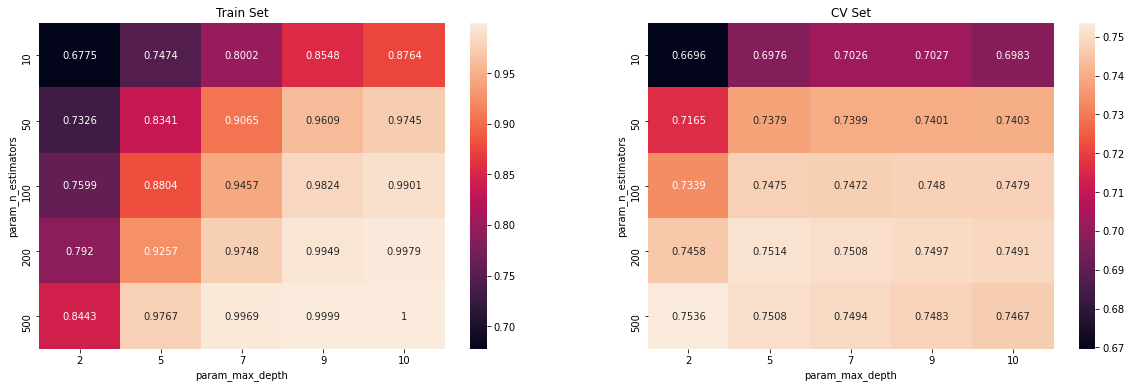

In [ ]:
max_scores = pd.DataFrame(GRD_CV.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores.mean_train_score, annot = True, fmt = '.4g', ax = ax[0])
sns.heatmap(max_scores.mean_test_score, annot = True, fmt = '.4g', ax = ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()

## <font color='blue'>>> Train model using the best hyperparameter</font>

In [68]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    global predictions1
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1 = predictions
    return predictions

In [69]:
def batch_predict(clf, data):

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
  
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

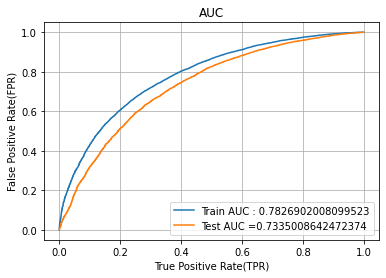

In [ ]:
XGB_Classifier = XGBClassifier(max_depth = 2, n_estimators = 500)

XGB_Classifier.fit(X_train_TFIDF, y_train)

y_train_pred = batch_predict(XGB_Classifier, X_train_TFIDF)    
y_test_pred = batch_predict(XGB_Classifier, X_test_TFIDF)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label = "Train AUC : " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC =" + str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## <font color='blue'>>> Confusion Matrix : X_train_TFIDF , X_test_TFIDF

the maximum value of tpr*(1-fpr) 0.5057052905581375 for threshold 0.838
the maximum value of tpr*(1-fpr) 0.45640033443590666 for threshold 0.848


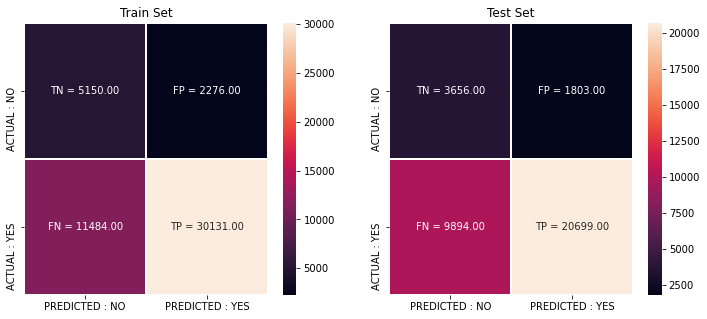

In [ ]:
conf_mat_train = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
conf_mat_test = confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), conf_mat_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), conf_mat_test.flatten())])).reshape(2,2)

sns.heatmap(conf_mat_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(conf_mat_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')

plt.show()

# <b><font color='red'>Task 2 :</font> </b>

## <b><font color='blue'>>> Applying GBDT (xgboost) on TFIDF W2V, </font><font color='red'> SET 2</font></b>

In [62]:
X_train_TFIDFW2V = hstack((X_train_school_state_pos, X_train_school_state_neg, X_train_clean_categories_pos, X_train_clean_categories_neg,
                           X_train_clean_subcategories_pos, X_train_clean_subcategories_neg, X_train_project_grade_category_pos,
                           X_train_project_grade_category_neg, X_train_teacher_prefix_pos, X_train_teacher_prefix_neg,
                           TFIDFW2V_vectors_text_train, TFIDFW2V_vectors_title_train, TFIDFW2V_vectors_project_resource_summary_train,
                           X_train_quantity_norm, X_train_teacher_number_of_previously_posted_projects_norm, X_train_price_norm)).tocsr()

X_CV_TFIDFW2V = hstack((X_cv_school_state_pos, X_cv_school_state_neg, X_cv_clean_categories_pos, X_cv_clean_categories_neg,
                        X_cv_clean_subcategories_pos, X_cv_clean_subcategories_neg, X_cv_project_grade_category_pos,
                        X_cv_project_grade_category_neg, X_cv_teacher_prefix_pos, X_cv_teacher_prefix_neg,
                        TFIDFW2V_vectors_text_cv, TFIDFW2V_vectors_title_cv, TFIDFW2V_vectors_project_resource_summary_cv,
                        X_cv_quantity_norm, X_cv_teacher_number_of_previously_posted_projects_norm, X_cv_price_norm)).tocsr()

X_test_TFIDFW2V = hstack((X_test_school_state_pos, X_test_school_state_neg, X_test_clean_categories_pos, X_test_clean_categories_neg,
                          X_test_clean_subcategories_pos, X_test_clean_subcategories_neg, X_test_project_grade_category_pos,
                          X_test_project_grade_category_neg, X_test_teacher_prefix_pos, X_test_teacher_prefix_neg,
                          TFIDFW2V_vectors_text_test, TFIDFW2V_vectors_title_test, TFIDFW2V_vectors_project_resource_summary_test,
                          X_test_quantity_norm, X_test_teacher_number_of_previously_posted_projects_norm, X_test_price_norm)).tocsr()

print(X_train_TFIDFW2V.shape)
print(X_CV_TFIDFW2V.shape)
print(X_test_TFIDFW2V.shape)

(49041, 913)
(24155, 913)
(36052, 913)


In [63]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

XGB_Classifier1 = XGBClassifier(class_weight = 'balanced', n_jobs = -1)
params = {'n_estimators': [10, 50, 100, 150], 'max_depth': [2, 5, 8]}
GRD_CV1 = GridSearchCV(XGB_Classifier1, params, cv = 3, scoring = 'roc_auc', n_jobs = -1, return_train_score = True)
GRD_CV1.fit(X_train_TFIDFW2V, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     class_weight='balanced',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8],
                         'n_estimators': [10, 50, 100, 150]},
     

In [64]:
print('Best Tuned Parameter : ')
print(GRD_CV1.best_estimator_)

Best Tuned Parameter : 
XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


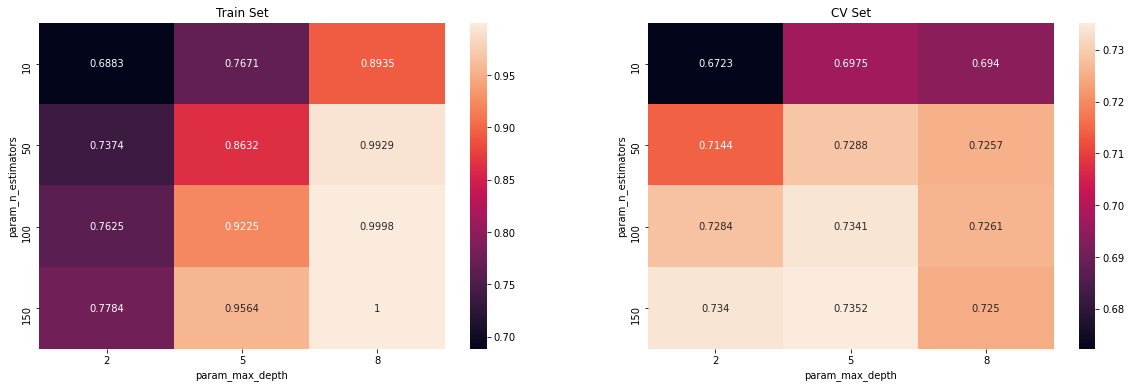

In [65]:
max_scores = pd.DataFrame(GRD_CV1.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1, 2, figsize = (20, 6))
sns.heatmap(max_scores.mean_train_score, annot = True, fmt = '.4g', ax = ax[0])
sns.heatmap(max_scores.mean_test_score, annot = True, fmt = '.4g', ax = ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()

## <font color='blue'>>> Hyperparameter Tuning to find best estimator using GridSearchCV :</font>

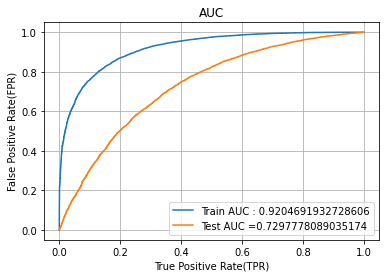

In [70]:
XGB_Classifier1 = XGBClassifier(max_depth = 5, n_estimators = 150)

XGB_Classifier1.fit(X_train_TFIDFW2V, y_train)

y_train_pred = batch_predict(XGB_Classifier1, X_train_TFIDFW2V)    
y_test_pred = batch_predict(XGB_Classifier1, X_test_TFIDFW2V)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label = "Train AUC : " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC =" + str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## <font color='blue'>>> Train model using the best hyperparameter</font>

the maximum value of tpr*(1-fpr) 0.7017201626272975 for threshold 0.812
the maximum value of tpr*(1-fpr) 0.454096182100235 for threshold 0.866


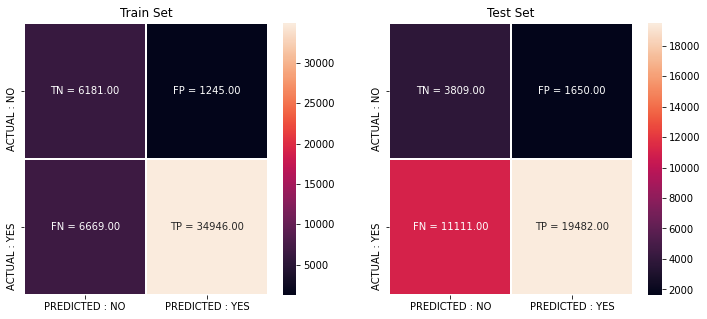

In [71]:
conf_mat_train = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
conf_mat_test = confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), conf_mat_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), conf_mat_test.flatten())])).reshape(2,2)

sns.heatmap(conf_mat_train, linewidths =.5, xticklabels = ['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(conf_mat_test, linewidths =.5, xticklabels = ['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')

plt.show()

<h1><font color='blue'>3. Summary</font></h1>

<br> as mentioned in the step 4 of instructions

In [72]:
# http://zetcode.com/python/prettytable/

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "N Estimators", "Max Depth", "Train AUC", "Test AUC"]
x.add_row(["TFIDF", "XGBOOST", 10, 5, 78, 73])
x.add_row(["TFIDF W2V", "XGBOOST", 10, 5, 92, 72])
print(x)

+------------+---------+--------------+-----------+-----------+----------+
| Vectorizer |  Model  | N Estimators | Max Depth | Train AUC | Test AUC |
+------------+---------+--------------+-----------+-----------+----------+
|   TFIDF    | XGBOOST |      10      |     5     |     78    |    73    |
| TFIDF W2V  | XGBOOST |      10      |     5     |     92    |    72    |
+------------+---------+--------------+-----------+-----------+----------+
